In [1]:
import pathlib

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython import display
from scipy.spatial import cKDTree
import h5py
from tqdm.auto import tqdm

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.dynamics import mockstream as ms

from scipy.interpolate import InterpolatedUnivariateSpline
import imf

import sys
if '../scripts' not in sys.path:
    sys.path.append('../scripts')
from streamsubhalosim import get_in_stream_frame, get_stream_track
from streamsubhaloplot import plot_sky_projections

# Load simulation metadata table

In [2]:
meta_path = pathlib.Path("../cache/stream-sims-metadata.fits")
allpars = at.QTable.read(meta_path)

In [10]:
mask = (
    np.isclose(allpars['M_subhalo'], 5e6 * u.Msun)
    & np.isclose(allpars['impact_v'], 50 * u.pc/u.Myr)
    & np.isclose(allpars['impact_b_fac'], 1.)
    & np.isclose(allpars['dx_hat'].data, [1., 0, 0]).all(axis=1)
    & np.isclose(allpars['t_post_impact'], 200 * u.Myr)
)
mask.sum()

1

In [11]:
allpars[mask]

M_subhalo,c_subhalo,impact_v,impact_b_fac,impact_b,t_post_impact,dx,dv,dx_hat,dv_hat,id
solMass,kpc,pc / Myr,,kpc,Myr,kpc,pc / Myr,,,
float64,float64,float64,float64,float64,float64,float64[3],float64[3],float64[3],float64[3],int64
5000000.0,0.11236241586936442,50.0,1.0,0.11236241586936442,200.0,0.10434100778812251 .. -2.8492464457965015e-06,0.002165341672438327 .. 49.11316220660972,1.0 .. 0.0,0.0 .. 1.0,756


In [12]:
sim_id = allpars[mask]['id'][0]
print(sim_id)

756


In [13]:
with h5py.File("../cache/stream-sims.hdf5", mode="r") as f:
    stream = gd.PhaseSpacePosition.from_hdf5(f[f"{sim_id}/stream"])
    impact = gd.PhaseSpacePosition.from_hdf5(f[f"{sim_id}/impact_site"])
    
    init_stream = gd.PhaseSpacePosition.from_hdf5(f["init/stream"])

In [14]:
stream_sfr = get_in_stream_frame(stream, impact)

In [15]:
init_stream_sfr = get_in_stream_frame(
    init_stream, impact, stream_frame=stream_sfr.replicate_without_data()
)
tracks = get_stream_track(init_stream_sfr, lon_lim=(-45, 45))

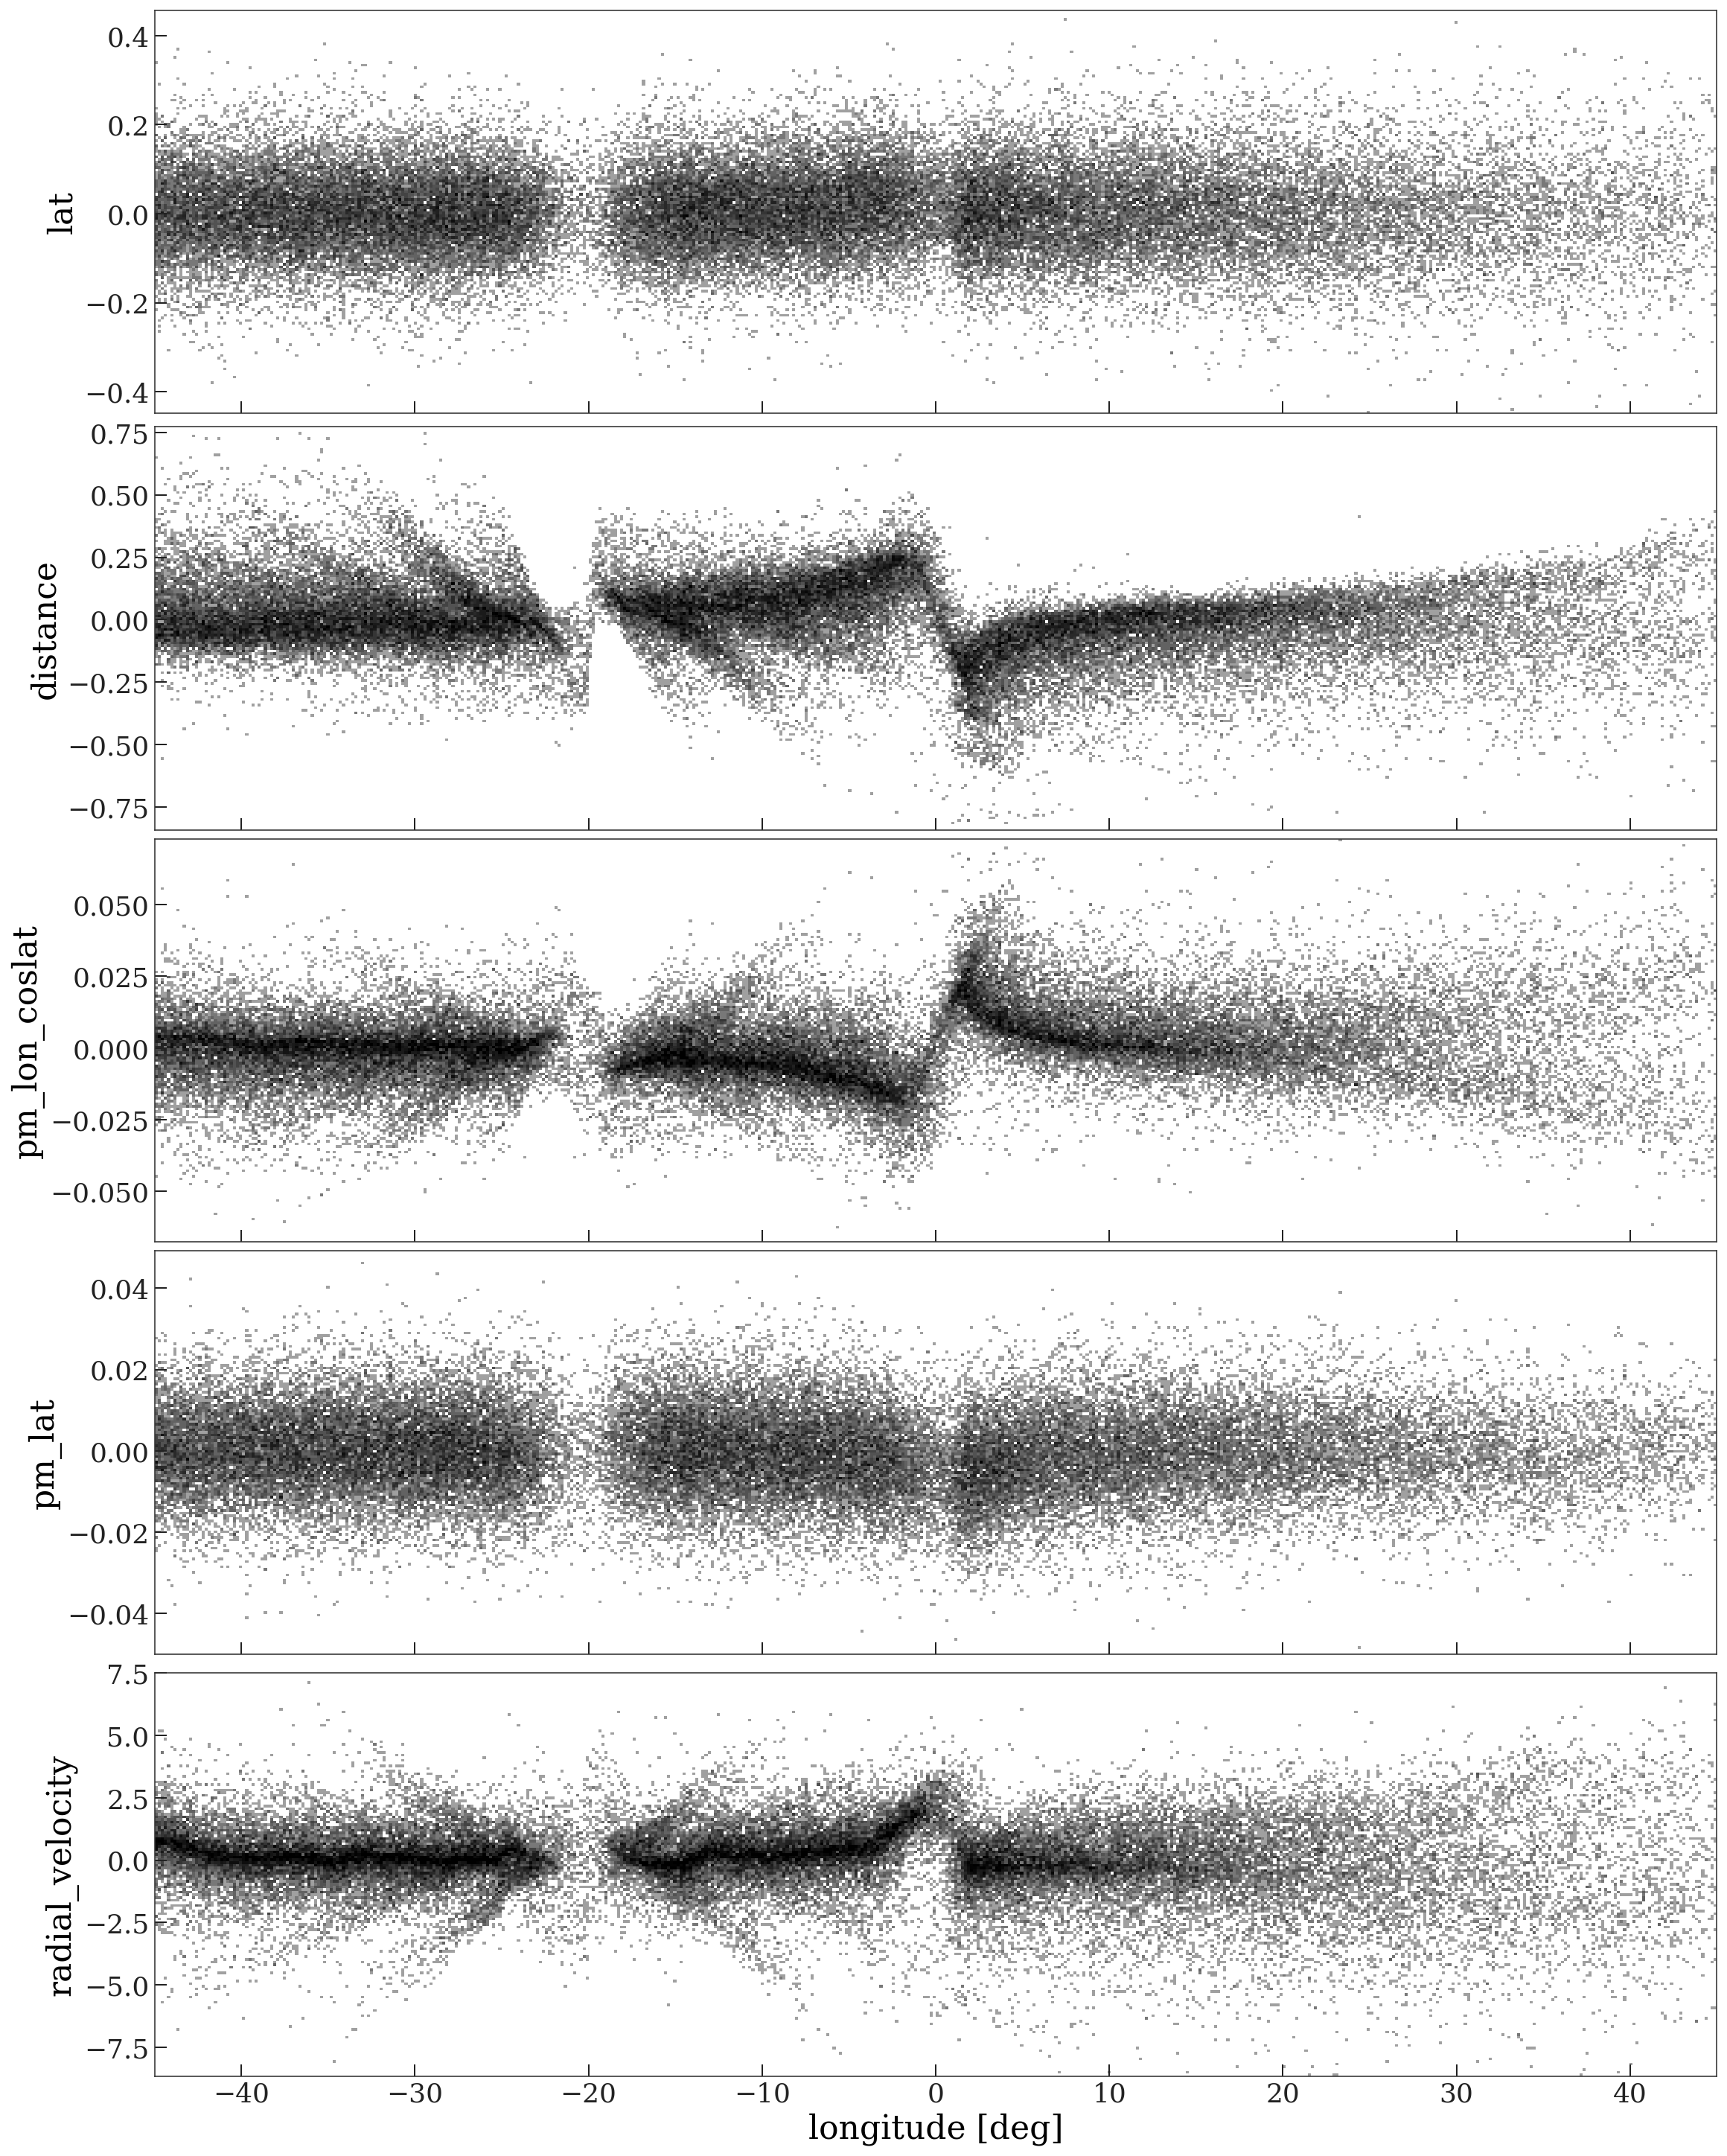

In [17]:
plot_sky_projections(stream_sfr, tracks=tracks);

# Stellar population

In [18]:
M_stream = 8e4 * u.Msun

In [19]:
iso = at.Table.read("/mnt/home/apricewhelan/data/isochrones/mist/FeH_-1.8_iso.fits")
iso = iso[np.isclose(iso["log10_isochrone_age_yr"], 10.0)]

(30.0, 12.0)

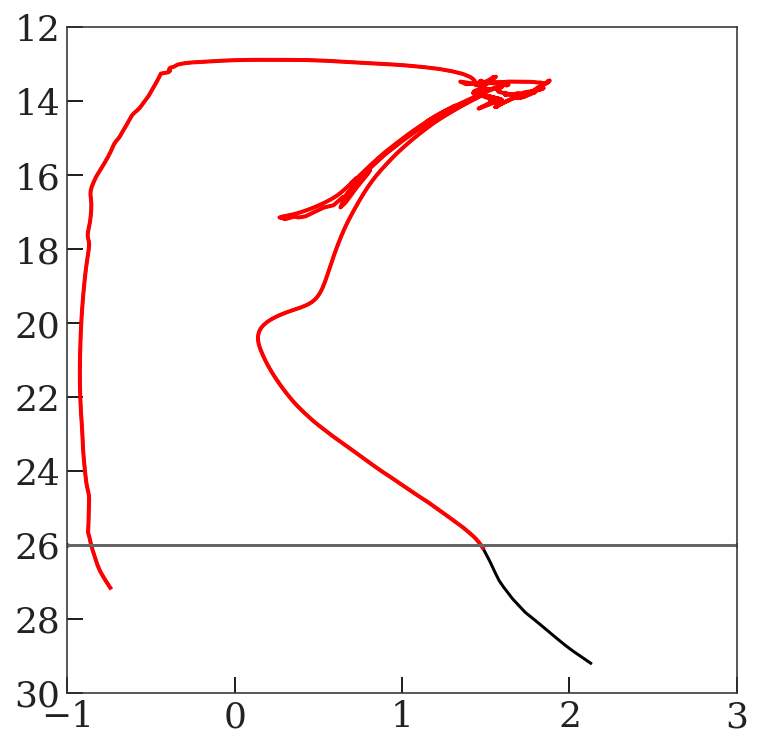

In [20]:
mean_dm = np.mean(stream_sfr.distance.distmod).value
plt.plot(iso["ps1_g"] - iso["ps1_i"], iso["ps1_r"] + mean_dm, marker="none", ls="-")

_mask = iso['initial_mass'] > 0.3
plt.plot((iso["ps1_g"] - iso["ps1_i"])[_mask], iso["ps1_r"][_mask] + mean_dm, marker="none", ls="-", lw=2, color='r')
plt.axhline(26)
plt.xlim(-1, 3)
plt.ylim(30, 12)

In [21]:
rng = np.random.default_rng(seed=42)

imf_masses = imf.make_cluster(M_stream.value)  # , mmax=iso['initial_mass'].max())

imf_mask = (imf_masses < iso["initial_mass"].max()) & (imf_masses > 0.3)
imf_masses = imf_masses[imf_mask]
# print(len(imf_masses), stream.shape[0])
imf_masses = rng.choice(imf_masses, size=stream.shape[0])

imf_masses.sum(), len(imf_masses)

Total cluster mass is 79999.9 (limit was 80000)


(38589.1841514993, 78560)

In [22]:
interp_mass2eep = InterpolatedUnivariateSpline(iso["initial_mass"], iso["EEP"], k=1)
imf_eeps = interp_mass2eep(imf_masses)

eep2mag_interps = {}
for mag in ["g", "r", "i"]:
    eep2mag_interps[mag] = InterpolatedUnivariateSpline(
        iso["EEP"], iso[f"ps1_{mag}"], k=1
    )

In [23]:
phot = at.Table()
for k, func in eep2mag_interps.items():
    phot[f"M_{k}"] = func(imf_eeps)

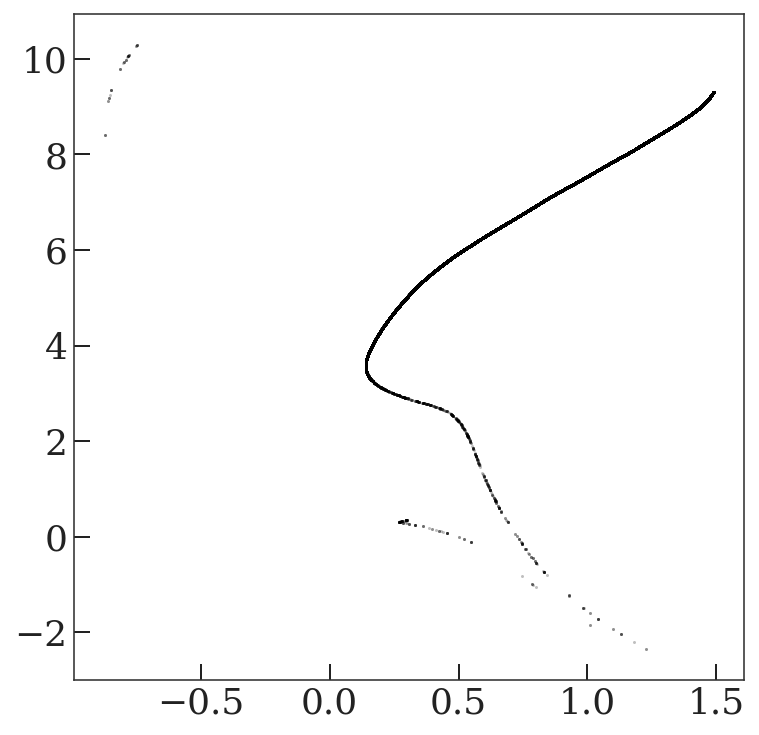

In [24]:
plt.plot(
    phot["M_g"] - phot["M_i"], phot["M_r"], marker="o", ls="none", ms=1.5, alpha=0.25
)

In [25]:
for k in eep2mag_interps.keys():
    phot[k] = phot[f"M_{k}"] + stream_sfr.distance.distmod.value

(30.0, 12.0)

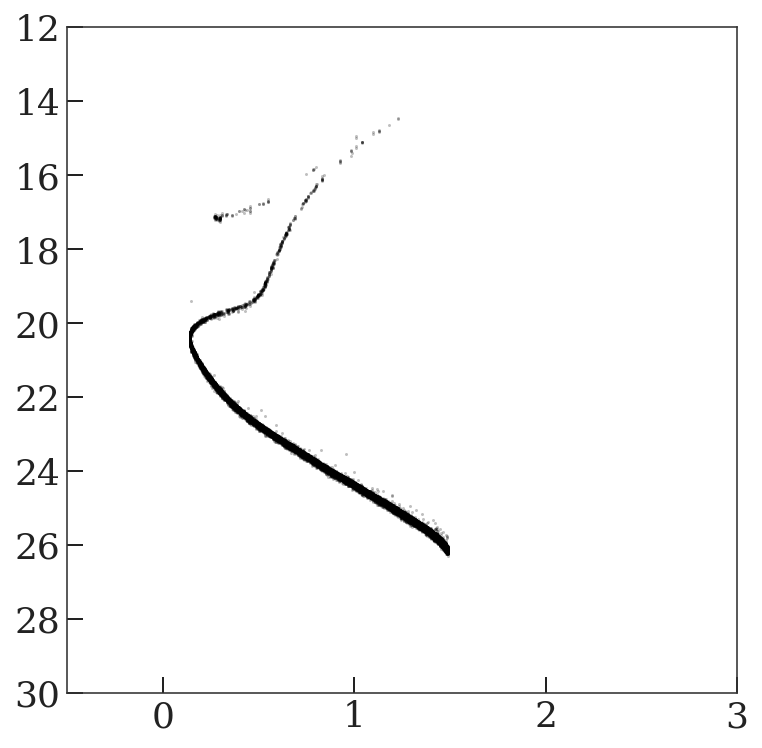

In [26]:
plt.plot(phot["g"] - phot["i"], phot["r"], marker="o", ls="none", ms=1.5, alpha=0.25)
plt.xlim(-0.5, 3)
plt.ylim(30, 12)

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 7.0000e+00, 1.8000e+01,
        3.8000e+01, 4.2240e+03, 6.6984e+04, 7.0300e+03, 2.5700e+02]),
 array([16.03128326, 16.99328084, 17.95527843, 18.91727602, 19.8792736 ,
        20.84127119, 21.80326878, 22.76526637, 23.72726395, 24.68926154,
        25.65125913]),
 <BarContainer object of 10 artists>)

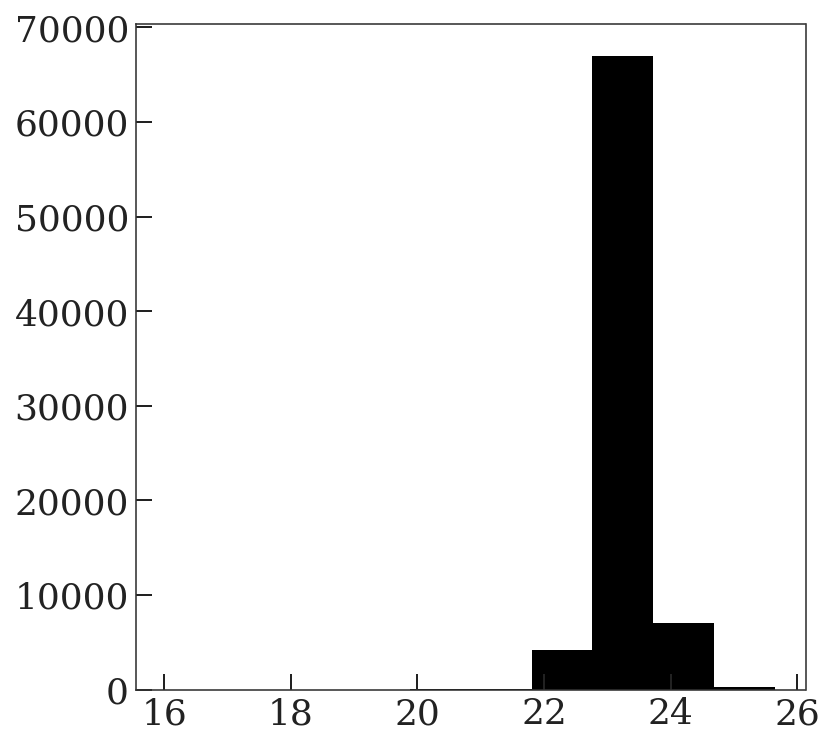

In [27]:
plt.hist(stream_sfr.distance.value)
# np.percentile(stream_sfr.distance.value, [1, 99])

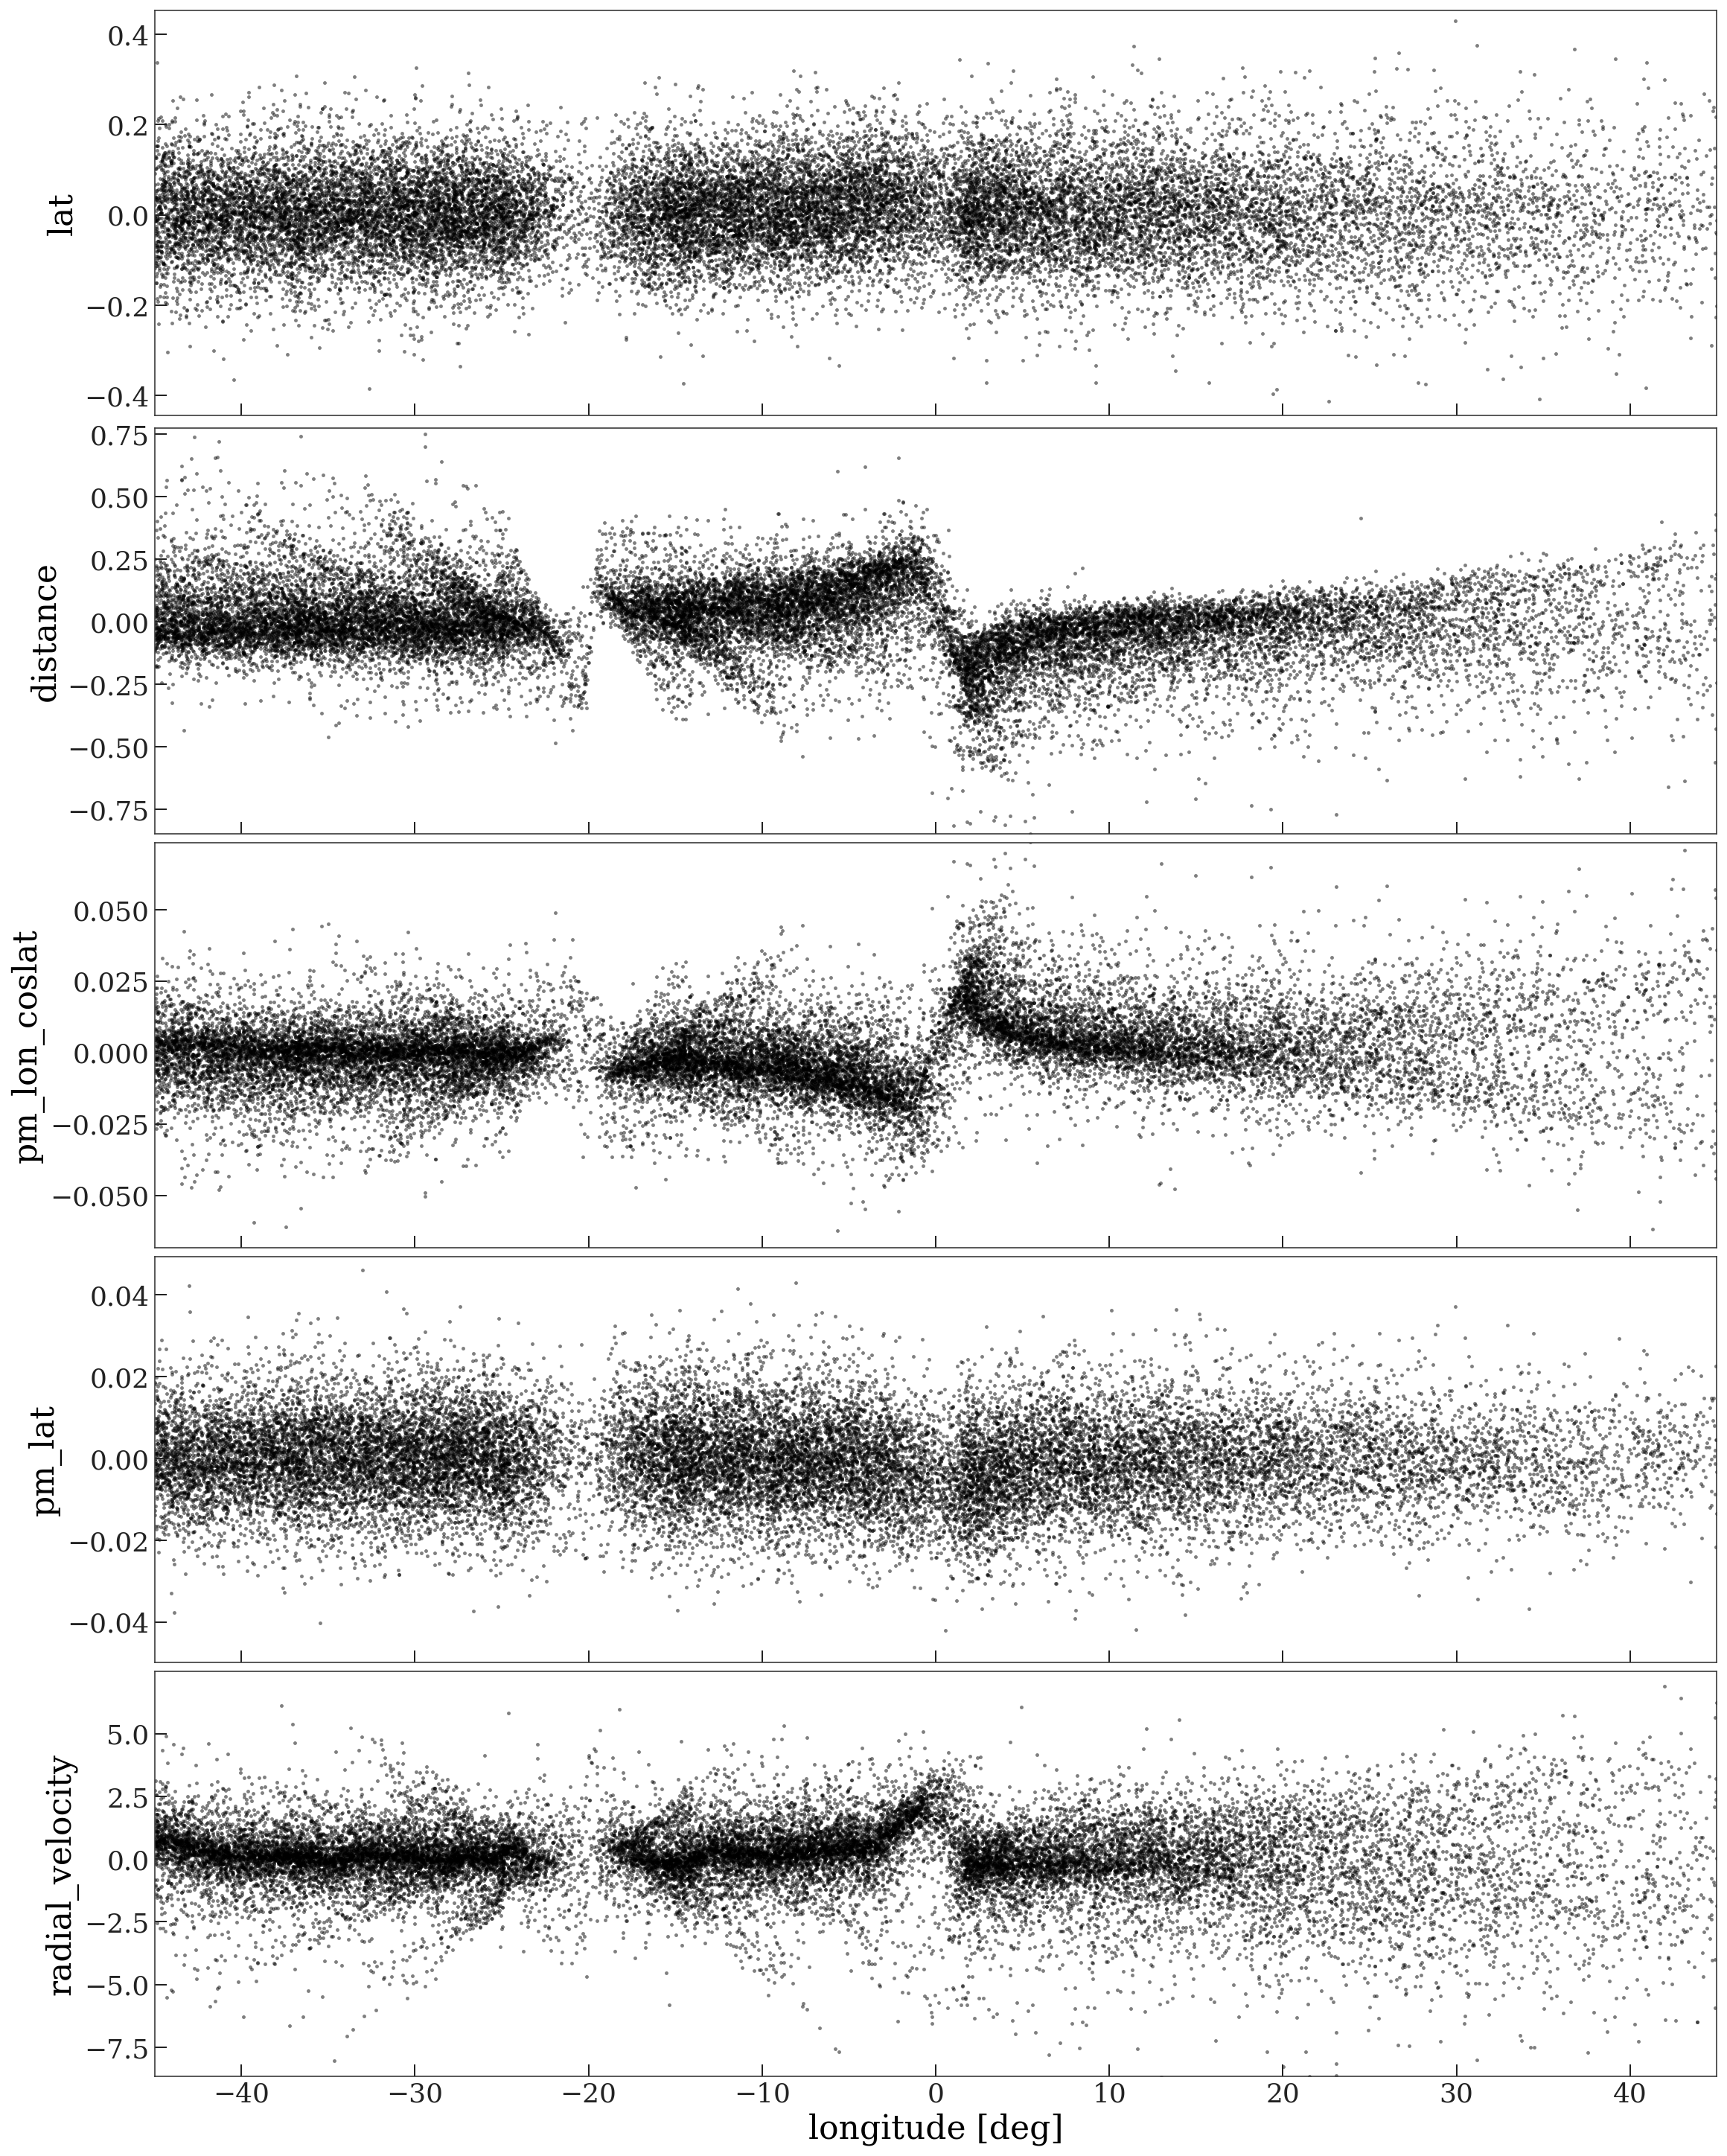

In [30]:
plot_sky_projections(
    stream_sfr[phot["g"] < 25.0], tracks=tracks, hist2d=False, scatter=True
)

In [44]:
def apply_error_model(stream_sfr, error_model, seed=None):
    rng = np.random.default_rng(seed)

    components = (
        list(stream_sfr.get_representation_component_names().keys())
        + list(stream_sfr.get_representation_component_names("s").keys())
    )

    err_data = {}
    for comp in components:
        if comp not in error_model:
            err_data[comp] = getattr(stream_sfr, comp)
            continue
            
        err = error_model[comp]
        y = getattr(stream_sfr, comp)
        if callable(err):
            err = err(y)
        err_data[comp] = rng.normal(
            y.value,
            err.to_value(y.unit)
        ) * y.unit

    frame = stream_sfr.replicate_without_data()
    return coord.SkyCoord(**err_data, frame=frame)

(<Figure size 1152x1440 with 5 Axes>,
 array([<Axes: ylabel='lat'>, <Axes: ylabel='distance'>,
        <Axes: ylabel='pm_lon_coslat'>, <Axes: ylabel='pm_lat'>,
        <Axes: xlabel='longitude [deg]', ylabel='radial_velocity'>],
       dtype=object))

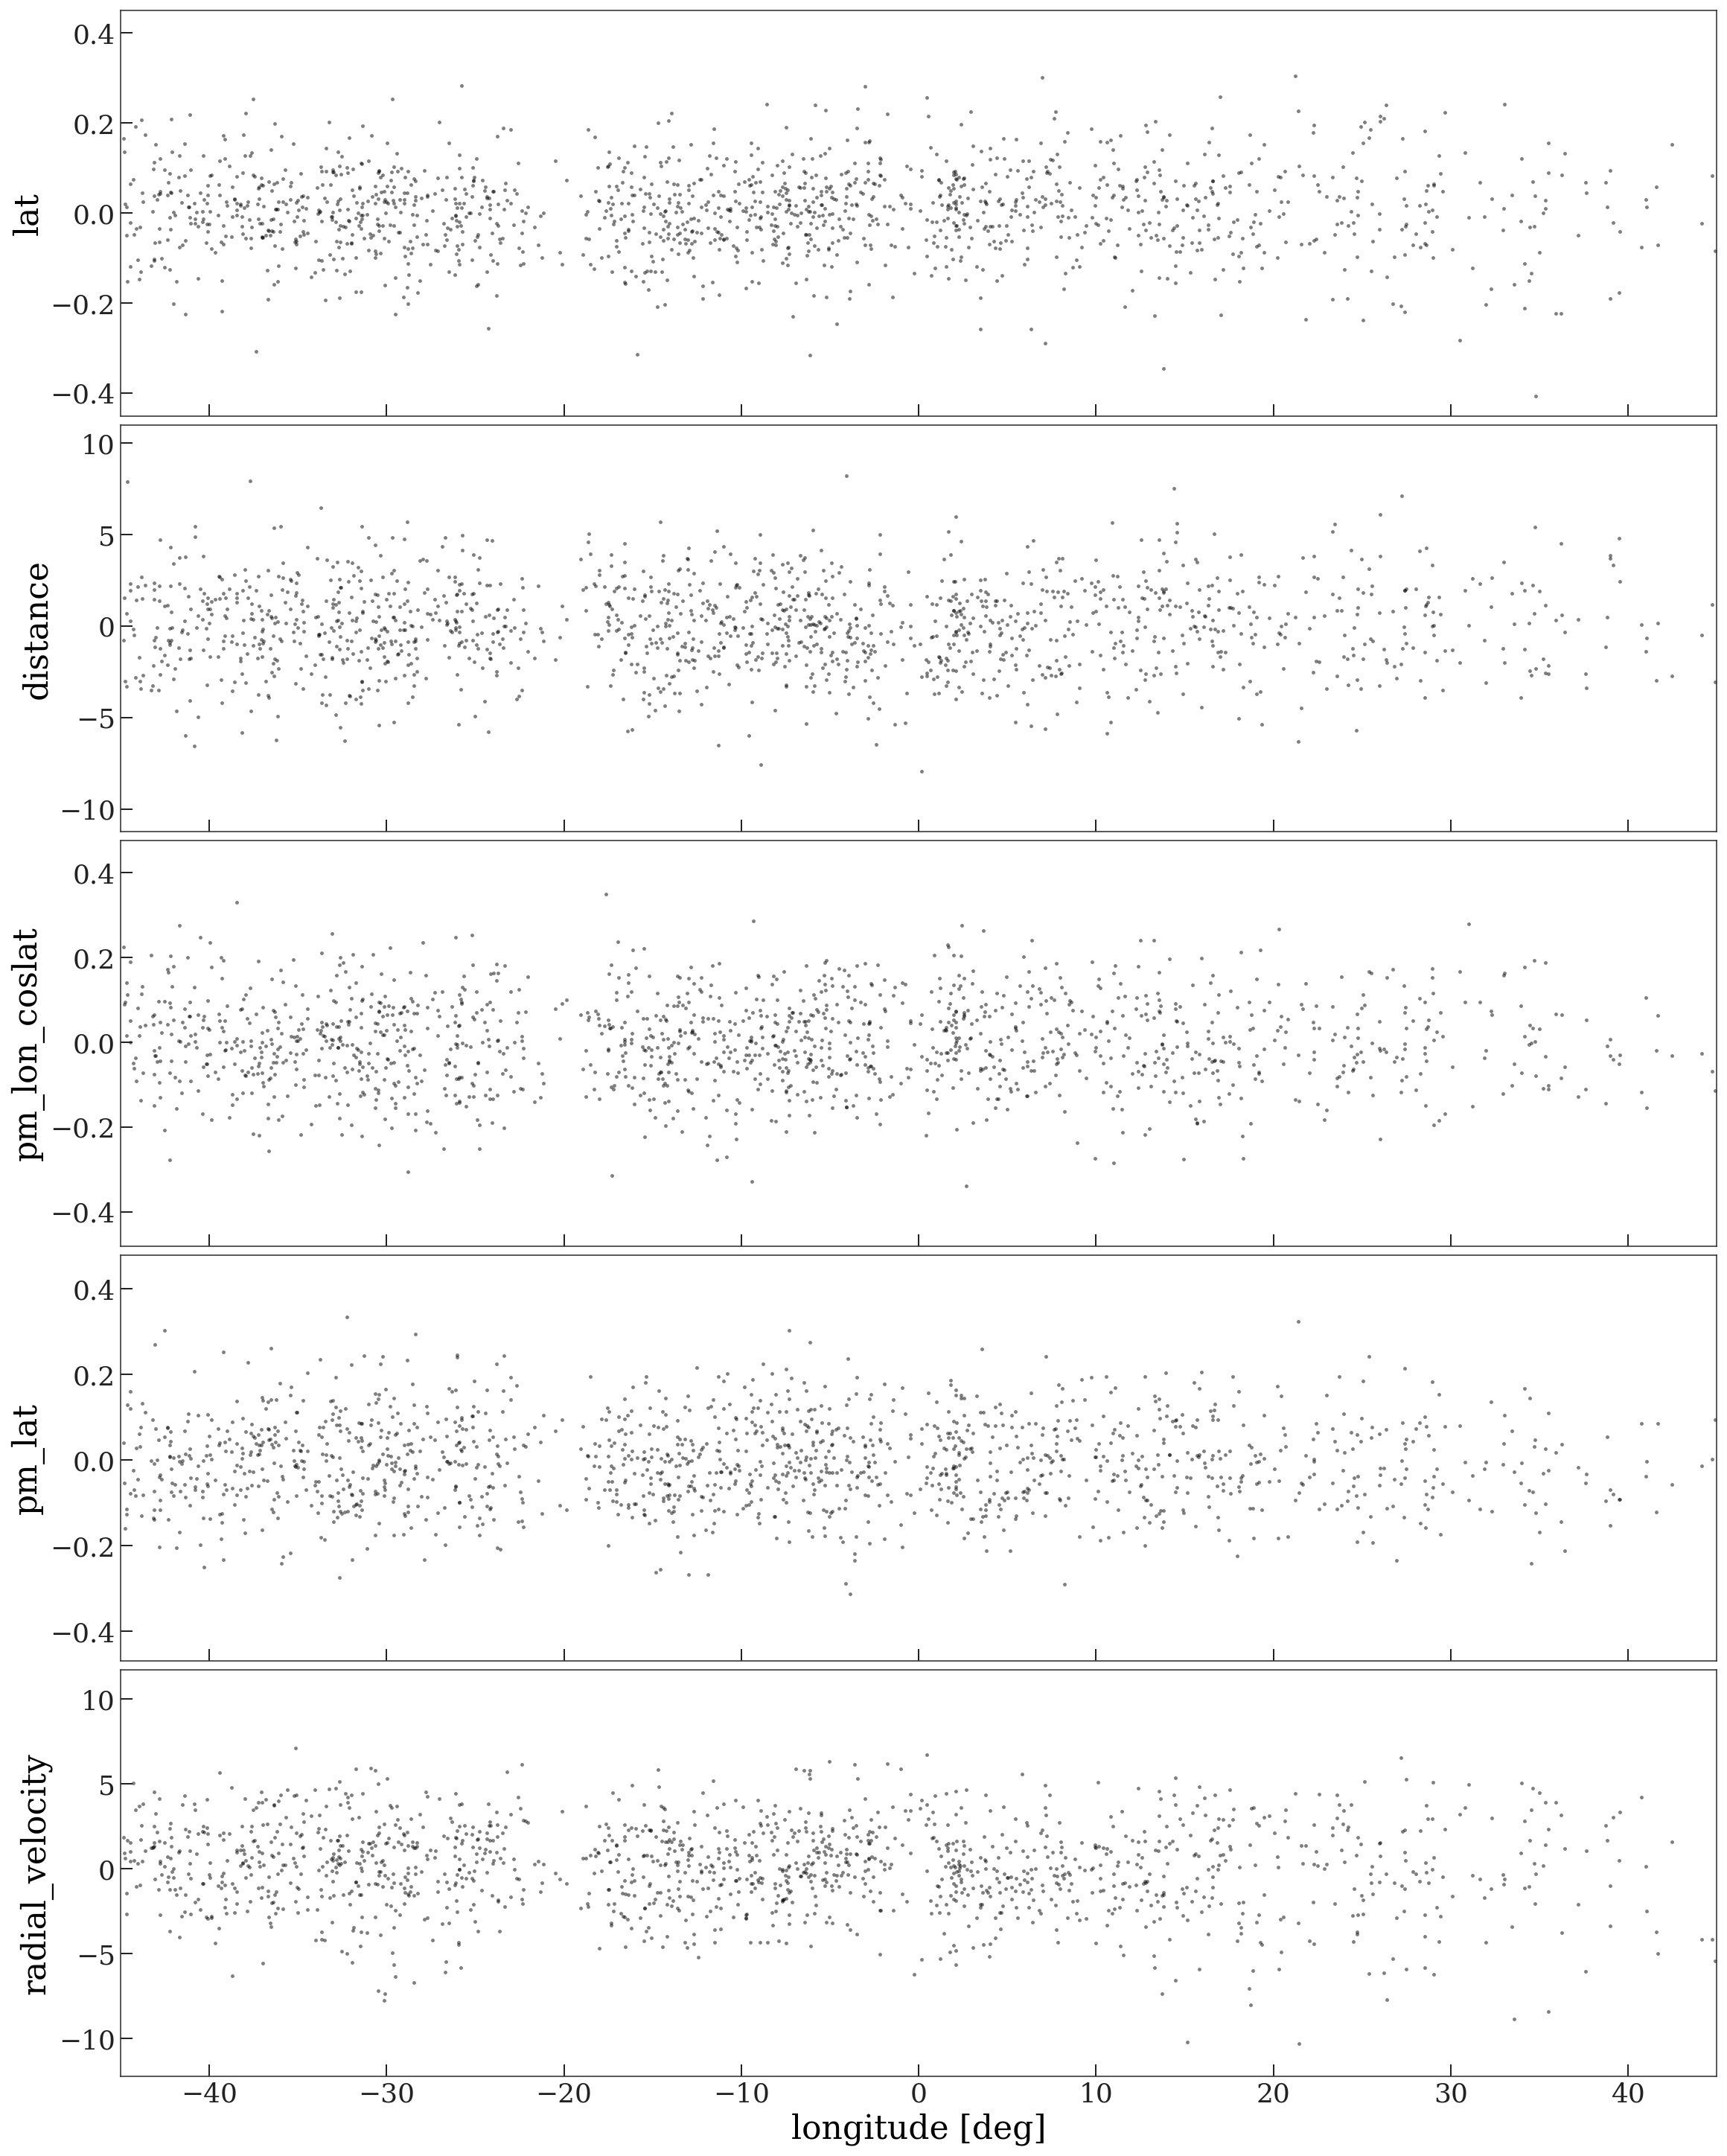

In [49]:
stream_sfr_err = apply_error_model(stream_sfr, {"distance": lambda d: 0.1 * d, "pm_lon_coslat": 0.1*u.mas/u.yr, "pm_lat": 0.1*u.mas/u.yr, "radial_velocity": 2*u.km/u.s})

plot_sky_projections(
    stream_sfr_err[phot["g"] < 20.7], tracks=tracks, hist2d=False, scatter=True
)

TODO: different error models

(all with 10% distance)
Gaia + DESI RV 
Roman + DESI RV
Roman + Via RV 

Density: Rubin photoemtry alone

TODO: background from MW stellar pop

TODO: how densely to sample the spectroscopic samples -- how many stars are needed per sq deg or whatever

TODO: question of star/galaxy separation